In [2]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import numpy as np

DATA_PATH = "data/"

In [29]:
df = pd.read_csv("data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [30]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [31]:
df = df.dropna()
df = df.reset_index()
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


<AxesSubplot:xlabel='dx', ylabel='count'>

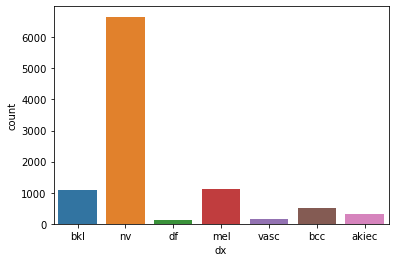

In [32]:
sns.countplot(x = "dx", data = df)

In [34]:
le = LabelEncoder()
df["dx"] = le.fit_transform(df["dx"])
df.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization
0,0,HAM_0000118,ISIC_0027419,2,histo,80.0,male,scalp
1,1,HAM_0000118,ISIC_0025030,2,histo,80.0,male,scalp
2,2,HAM_0002730,ISIC_0026769,2,histo,80.0,male,scalp
3,3,HAM_0002730,ISIC_0025661,2,histo,80.0,male,scalp
4,4,HAM_0001466,ISIC_0031633,2,histo,75.0,male,ear


In [8]:
image_size = 128

class HAM10000(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = nn.Sequential(transforms.Resize(image_size))
        
    def __len__(self):
        return len(df)
    
    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_id"]
        image = read_image(DATA_PATH + "all_images/" + path + ".jpg").float()
        image = self.transform(image)
        
        label = self.df.loc[idx, "dx"]
        
        return image, label

In [9]:
dataset = HAM10000(df)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

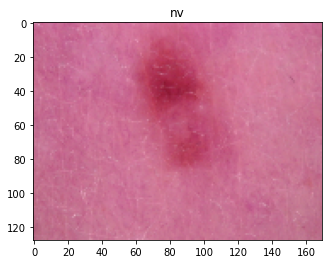

In [10]:
images, labels = next(iter(dataloader))

plt.imshow(images[0].int().permute(1, 2, 0))
plt.title(labels[0])
plt.show()

In [46]:
class convHAM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding = 1)
        
        self.fc1 = nn.Linear(8 * 10 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 4, 4)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 4, 4)
        
        x = x.view(-1, 8 * 10 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x
    
model = convHAM()
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─Conv2d: 1-2                            880
├─Linear: 1-3                            153,720
├─Linear: 1-4                            10,164
├─Linear: 1-5                            595
Total params: 165,815
Trainable params: 165,815
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─Conv2d: 1-2                            880
├─Linear: 1-3                            153,720
├─Linear: 1-4                            10,164
├─Linear: 1-5                            595
Total params: 165,815
Trainable params: 165,815
Non-trainable params: 0

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 6